In [1]:
symphony_build_path = '/home/alex/Documents/Spring_2016/symphony/symphony/build'
%matplotlib inline

#import symphony to use exact integrator or fitting formulae
import sys
sys.path.append(symphony_build_path)
import symphonyPy as sp

#import other useful libraries
import numpy as np
import pylab as pl
import numpy.random as random
from numpy.random import normal
import scipy.special as special
from scipy.interpolate import splrep, splev, interp1d
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy.stats.distributions import norm
from scipy.optimize import curve_fit

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [2]:
#define constants in Gaussian CGS units
m         = 9.1093826e-28
c         = 2.99792458e10
e         = 4.80320680e-10
h         = 6.6260693e-27

#-------------------set symphony's parameters---------------#
#calculates j_nu if True, alpha_nu if false
emiss            = True

#choose frequency nu in Hz
nu = 230e9

#polarization as component of S = {I,Q,U,V}
stokes_parameter = sp.STOKES_I

#sp.POWER_LAW, sp.MAXWELL_JUETTNER, or sp.KAPPA_DIST
distribution     = sp.POWER_LAW

#dimensionless electron temperature for MAXWELL_JUETTNER (thermal) distribution
theta_e          = 10.

#parameters for the power-law distribution (index is p)
gamma_min        = 1.
gamma_max        = 1000.
gamma_cutoff     = 1e10
p                = 3.

#parameters for the kappa distribution
kappa            = 3.5
w                = 10.

In [3]:
#Euler-Rodrigues rotation matrix, as implemented by user "unutbu" from
# http://stackoverflow.com/questions/6802577/python-rotation-of-3d-vector
#It matches the literature Euler-Rodrigues formula, and has been shown to
#produce the correct results. This version provides a clockwise rotation, 
#whereas its transpose (as on Wikipedia) produces a counterclockwise rotation.
def rotation_matrix(axis, theta):
    axis = np.asarray(axis)
    theta = np.asarray(theta)
    axis = axis/np.sqrt(np.dot(axis, axis))
    a = np.cos(theta/2.0)
    b, c, d = -axis*np.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

#a wrapper for symphony's fitting formulae function
def j_nu_or_alpha_nu(nu, obs_angle, B_mag, n_e, stokes_parameter):
    
    #in symphony's coordinates STOKES_U = 0; use STOKES_Q and apply rotation below
    if stokes_parameter == sp.STOKES_U:
        stokes_parameter = sp.STOKES_Q
    
    if emiss == True:
        norm_j_nu = np.mean(n_e) * e**2. * (e * np.mean(B_mag) / (2. * np.pi * m * c)) / c
        
        return np.vectorize(sp.j_nu_fit_py)(nu, B_mag, n_e, obs_angle, distribution, 
                              stokes_parameter, theta_e, p, gamma_min, 
                              gamma_max, gamma_cutoff, kappa, w) / norm_j_nu
    else:
        norm_alpha_nu = np.mean(n_e) * e**2. / (nu * m * c)
        
        return np.vectorize(sp.alpha_nu_fit_py)(nu, B_mag, n_e, obs_angle, distribution, 
                                  stokes_parameter, theta_e, p, gamma_min, 
                                  gamma_max, gamma_cutoff, kappa, w) / norm_alpha_nu

In [4]:
datafiles_path = '/home/alex/Documents/Spring_2016/'

num_skip = 32
B_scale  = 30.
#obs_vector = [1, 0, 0] #choose observer vector; does not have to be normalized (normalization taken care of below)

In [5]:
#import data

#datafiles_path = '/home/mani/work/kunz_data/'
B_x = np.loadtxt(datafiles_path + 'mirror_bx.out')[::num_skip, ::num_skip] * B_scale
B_y = np.loadtxt(datafiles_path + 'mirror_by.out')[::num_skip, ::num_skip] * B_scale
B_z = np.loadtxt(datafiles_path + 'mirror_bz.out')[::num_skip, ::num_skip] * B_scale
n_e = np.loadtxt(datafiles_path + 'mirror_d.out')[::num_skip, ::num_skip]
B_mag = np.sqrt(B_x**2. + B_y**2. + B_z**2.)

B_x_avg   = np.mean(B_x)
B_y_avg   = np.mean(B_y)
B_z_avg   = np.mean(B_z)
B_mag_avg = np.mean(B_mag)
n_e_avg   = np.mean(n_e)

B_avg_vector = [B_x_avg, B_y_avg, B_z_avg]
B_avg_vector    = B_avg_vector / np.linalg.norm(B_avg_vector)

B_vector     = [B_x, B_y, B_z]
b_hat        = B_vector / np.sqrt(B_x**2. + B_y**2. + B_z**2.)

In [6]:
#desired angle between observer vector and mean B
theta       = np.pi/3.

cone_resolution = 25


#rotates observer vector in plane
axis_of_rot = [0, B_avg_vector[2], -B_avg_vector[1]]
axis_of_rot = axis_of_rot / np.linalg.norm(axis_of_rot)

obs_vector  = np.dot(rotation_matrix(axis_of_rot, theta), B_avg_vector)

k_parallel = (np.dot(obs_vector, B_avg_vector) / np.dot(B_avg_vector, B_avg_vector)) * B_avg_vector

angle_to_mean_field = np.arccos(np.dot(B_avg_vector, obs_vector) / (np.linalg.norm(B_avg_vector) 
                                                                     * np.linalg.norm(obs_vector)))
exact_j_nu_array = 0.

avg_j_nu = 0.

for cone_point in range(cone_resolution):
    
    cone_rot = (1.0 * cone_point / cone_resolution * 2.*np.pi)
    
    k_vector = np.dot(rotation_matrix(B_avg_vector, cone_rot), obs_vector)

    k_vector = k_vector / np.linalg.norm(k_vector)
    
    obs_angle = np.arccos((B_x * k_vector[0]
                            + B_y * k_vector[1]
                            + B_z * k_vector[2])
                            / (np.linalg.norm(k_vector)*B_mag))
    
    
    
    obs_vector_array = [np.full(np.shape(B_x), k_vector[0]),
                   np.full(np.shape(B_x), k_vector[1]),
                   np.full(np.shape(B_x), k_vector[2])]  

    b_hat_dot_k_hat = b_hat[0] * obs_vector_array[0] + b_hat[1] * obs_vector_array[1] + b_hat[2] * obs_vector_array[2]


    e_alpha_unnormed = (b_hat - obs_vector_array * b_hat_dot_k_hat)
    e_alpha_norm = np.sqrt(e_alpha_unnormed[0]**2. + e_alpha_unnormed[1]**2. + e_alpha_unnormed[2]**2.)

    e_alpha_normed = [e_alpha_unnormed[0]/e_alpha_norm, e_alpha_unnormed[1]/e_alpha_norm, e_alpha_unnormed[2]/e_alpha_norm]


    #create e_alpha_prime #TODO: check this
    e_alpha_p_not_perp = B_avg_vector


    e_alpha_p_perp = (e_alpha_p_not_perp - k_vector * np.dot(k_vector, e_alpha_p_not_perp))

    #TODO: CHECK THIS
    if(np.linalg.norm(e_alpha_p_perp) == 0.):
        e_alpha_p_normed = e_alpha_p_not_perp
    else:
        e_alpha_p_normed = e_alpha_p_perp / np.linalg.norm(e_alpha_p_perp)

    xi = np.arccos((e_alpha_normed[0] * e_alpha_p_normed[0] +
                       e_alpha_normed[1] * e_alpha_p_normed[1] +
                       e_alpha_normed[2] * e_alpha_p_normed[2]))

    xi = np.nan_to_num(xi)

    if(stokes_parameter == sp.STOKES_I or stokes_parameter == sp.STOKES_V):
        exact_j_nu_array += j_nu_or_alpha_nu(nu, obs_angle, B_mag, n_e, stokes_parameter)
    elif(stokes_parameter == sp.STOKES_Q):
        exact_j_nu_array += j_nu_or_alpha_nu(nu, obs_angle, B_mag, n_e, stokes_parameter) * np.cos(2. * xi)
    elif(stokes_parameter == sp.STOKES_U):
        exact_j_nu_array += j_nu_or_alpha_nu(nu, obs_angle, B_mag, n_e, stokes_parameter) * np.sin(2. * xi)
                
  
exact_j_nu_array_cone_averaged = exact_j_nu_array / cone_resolution
#avg_j_nu = avg_j_nu / cone_resolution

exact  = np.mean(exact_j_nu_array_cone_averaged)

if(stokes_parameter == sp.STOKES_U):
    avgs = 0.
else:
    avgs   = j_nu_or_alpha_nu(nu, angle_to_mean_field, B_mag_avg, n_e_avg, stokes_parameter)

print exact, avgs, (exact - avgs)/exact

0.00111409471151 0.000935059776166 0.160699923891


Fitted mean               =  1.04276907196
Fitted standard deviation =  0.137398569622


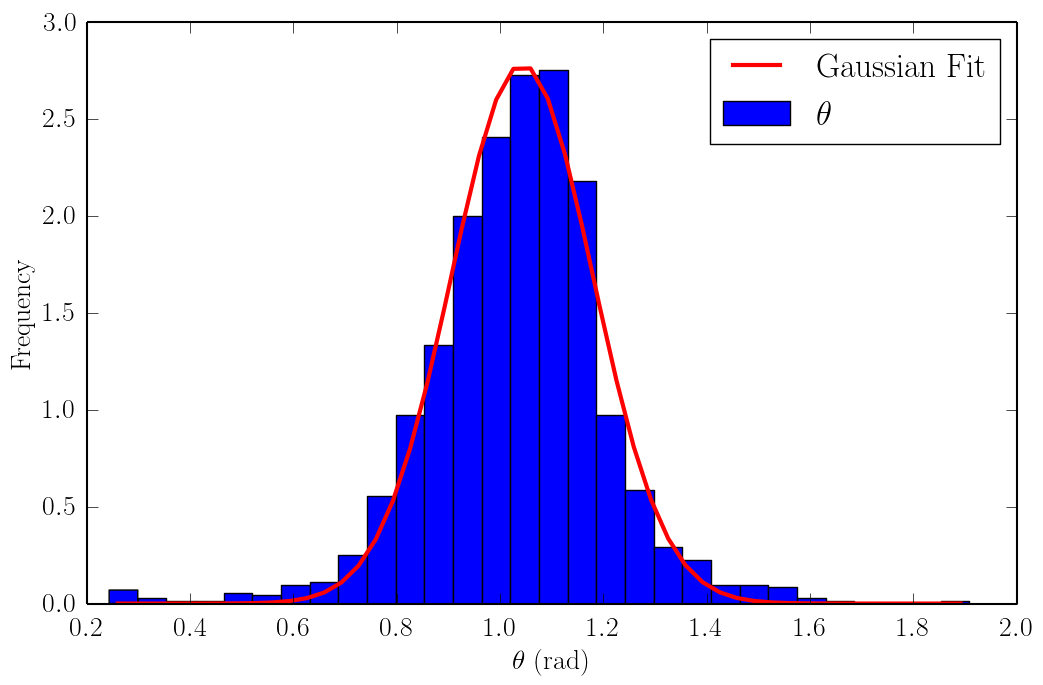

In [7]:
#fit Gaussian probability distribution to obs_angle distribution
data = obs_angle.flatten()
hist, bin_edges = np.histogram(data, density=True, bins=50)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

#pl.plot(bin_centres, hist, label='$\\mathrm{Input~data}$')
#pl.plot(bin_centres, hist_fit, label='$\\mathrm{Gaussian~Fit}$')
#pl.xlabel('$\\theta$')
#pl.ylabel('$\\mathrm{Frequency}$')

fit_mu    = coeff[1]
fit_sigma = coeff[2]

#pl.show()
pl.hist(obs_angle.flatten(), bins=30, normed=True, label='$\\theta$')
pl.plot(bin_centres, hist_fit, label='$\\mathrm{Gaussian~Fit}$', lw=3, c='r')
pl.xlabel('$\\theta \\mathrm{~(rad)}$')
pl.ylabel('$\\mathrm{Frequency}$')

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print 'Fitted mean               = ', fit_mu
print 'Fitted standard deviation = ', fit_sigma 
pl.legend()
pl.show()

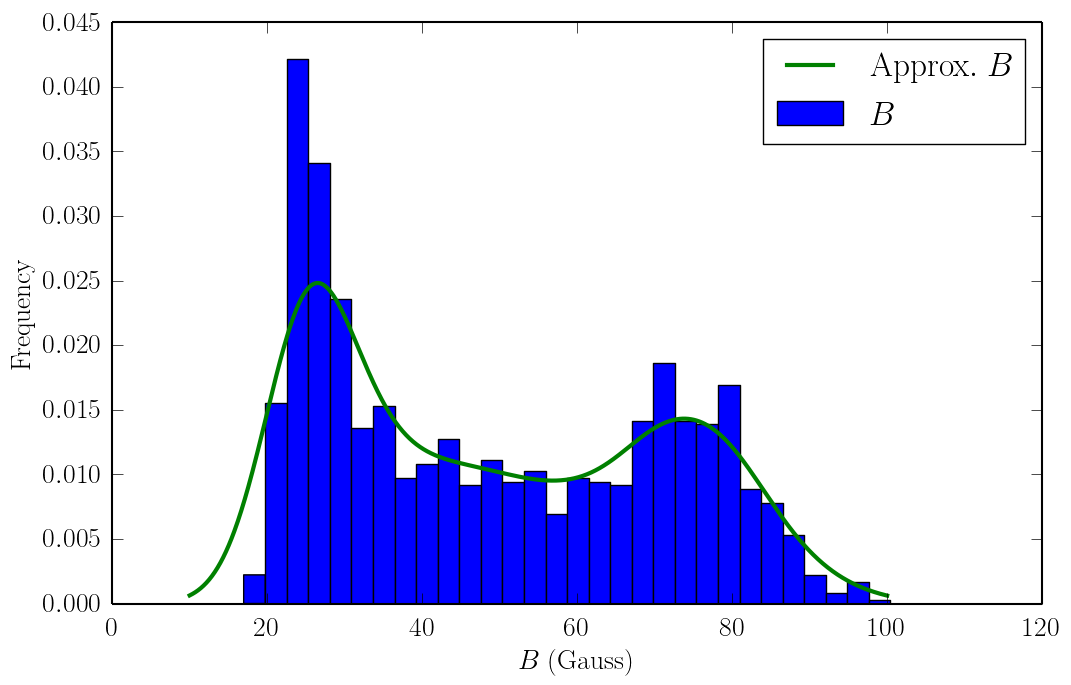

In [8]:
def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)

from scipy.interpolate import splrep, splev, interp1d
# The grid we'll use for plotting
min_x = 10.
max_x = 100.
num_points = 1000
x_grid = np.linspace(min_x, max_x, num_points)

bandwith_set = 5.

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = B_mag.flatten()

pdf = kde_statsmodels_u(x, x_grid, bandwidth=bandwith_set)

width_of_step = (max_x - min_x) / num_points
cdf = np.cumsum(pdf) * width_of_step
tck = splrep(x_grid, cdf)
tck_inv = splrep(cdf, x_grid)

#need to remove erroneous values of approximate_dist that are greater than max(B_mag)
approximate_dist = splev(np.random.rand(1296+6, 1).flatten(), tck_inv)
approximate_dist = approximate_dist[approximate_dist < np.amax(B_mag)]
#print np.amax(approximate_dist)

#pl.hist(approximate_dist, bins=30, normed=True, label='$\\mathrm{approx.~dist.}$');
pl.hist(B_mag.flatten(),  bins=30, normed=True, label='$B$');
pl.plot(x_grid, pdf, linewidth=3, label='$\\mathrm{Approx.~}B$')
pl.legend(loc='upper right')
pl.xlabel('$B\\mathrm{~(Gauss)}$')
pl.ylabel('$\\mathrm{Frequency}$')

In [9]:
#pl.contourf(n_e, 100, cmap='ocean')
#pl.xlabel('$x$')
#pl.ylabel('$y$')
#pl.colorbar()

In [10]:
#We now want to calculate j_nu() using theta sampled from an approximation to its
# actual distribution (a Gaussian).  We want to do the same with the distribution
# of |B|, though before we do that we need to figure out how to randomly sample
# numbers from the KDE approximate PDF for |B|.

size = len(obs_angle.flatten())
n_e_avg = np.mean(n_e)
#obs_angle_approx_samples = np.random.normal(fit_mu, fit_sigma, size)
obs_angle_approx_samples = np.random.normal(angle_to_mean_field, fit_sigma, size)



approx_theta    = j_nu_or_alpha_nu(nu, obs_angle_approx_samples, 
                                                np.mean(B_mag), np.mean(n_e), stokes_parameter)

approx_theta_ne = j_nu_or_alpha_nu(nu, obs_angle_approx_samples, 
                                                np.mean(B_mag), np.mean(n_e), stokes_parameter)

approx_B        = j_nu_or_alpha_nu(nu, angle_to_mean_field, approximate_dist, np.mean(n_e), stokes_parameter)
approx_B_ne     = j_nu_or_alpha_nu(nu, angle_to_mean_field, approximate_dist, np.mean(n_e), stokes_parameter)
approx_all      = j_nu_or_alpha_nu(nu, obs_angle_approx_samples, approximate_dist, n_e_avg, stokes_parameter)


j_nu_approx_theta = np.mean(approx_theta)
j_nu_approx_theta_ne = np.mean(approx_theta_ne)
j_nu_approx_B = np.mean(approx_B)
j_nu_approx_B_ne = np.mean(approx_B_ne)
j_nu_approx_all = np.mean(approx_all)


print 'Exact: ', exact, ' Avgs:              ', avgs,                 ' Error: ', (exact - avgs) / exact
print 'Exact: ', exact, ' approx theta, n_e: ', j_nu_approx_theta_ne, ' Error: ', (exact - j_nu_approx_theta_ne)/ exact
print 'Exact: ', exact, ' approx B, n_e:     ', j_nu_approx_B_ne,     ' Error: ', (exact - j_nu_approx_B_ne)    / exact
print 'Exact: ', exact, ' approx all:        ', j_nu_approx_all,      ' Error: ', (exact - j_nu_approx_all)    / exact

Exact:  0.00111409471151  Avgs:               0.000935059776166  Error:  0.160699923891
Exact:  0.00111409471151  approx theta, n_e:  0.00092401712554  Error:  0.170611693969
Exact:  0.00111409471151  approx B, n_e:      0.00113116552145  Error:  -0.0153225841191
Exact:  0.00111409471151  approx all:         0.00112046461253  Error:  -0.00571755789759
